In [6]:
# some imports
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rc('font', size=12) 
plt.rc('figure', figsize = (12, 5))

# Settings for the visualizations
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})

import pandas as pd
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# create output folder
if not os.path.exists('output'):
    os.makedirs('output')
if not os.path.exists('output/session1'):
    os.makedirs('output/session1')

C:\Users\mberm\AppData\Local\Temp\ipykernel_10996\1804143763.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from project_tools import AddHouseSize
from sklearn.linear_model import LinearRegression

## 1. Get the dataset and general data structure

### 1.1 Càrrega dades

In [8]:
train_set = pd.read_csv('data/train_set.csv',index_col=0) 
test_set = pd.read_csv('data/test_set.csv',index_col=0) 

### 1.2 General description

In [9]:
# print the dataset size
print("There is", train_set.shape[0], "samples")
print("Each sample has", train_set.shape[1], "features")
train_set.head(5)

There is 5432 samples
Each sample has 21 features


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
index,,,,,,,,,,,,,,,,,,,,,
0,Aberfeldie,241 Buckley St,4,h,1380000.0,VB,Nelson,12/08/2017,7.5,3040.0,4.0,2.0,2.0,766.0,NaN,NaN,Moonee Valley,-37.75595,144.90551,Western Metropolitan,1543.0
1,Northcote,67 Charles St,2,h,1100000.0,SP,Jellis,20/05/2017,5.5,3070.0,2.0,1.0,1.0,189.0,NaN,NaN,Darebin,-37.77670,144.99240,Northern Metropolitan,11364.0
2,Balwyn North,42 Maud St,3,h,1480000.0,PI,Jellis,15/10/2016,9.2,3104.0,3.0,1.0,4.0,605.0,116.0,1950.0,Boroondara,-37.79510,145.06960,Southern Metropolitan,7809.0
3,Brunswick,13 Percy St,3,h,1055000.0,S,Nelson,7/05/2016,5.2,3056.0,3.0,1.0,1.0,324.0,NaN,1930.0,Moreland,-37.76530,144.95860,Northern Metropolitan,11918.0
4,Templestowe Lower,253 Thompsons Rd,4,h,1000000.0,VB,hockingstuart,13/08/2016,13.8,3107.0,4.0,3.0,2.0,728.0,164.0,1970.0,Manningham,-37.76800,145.10270,Eastern Metropolitan,5420.0


### 1.4. Cast data types

In [10]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5432 entries, 0 to 5431
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         5432 non-null   object 
 1   Address        5432 non-null   object 
 2   Rooms          5432 non-null   int64  
 3   Type           5432 non-null   object 
 4   Price          5432 non-null   float64
 5   Method         5432 non-null   object 
 6   SellerG        5432 non-null   object 
 7   Date           5432 non-null   object 
 8   Distance       5432 non-null   float64
 9   Postcode       5432 non-null   float64
 10  Bedroom2       5432 non-null   float64
 11  Bathroom       5432 non-null   float64
 12  Car            5407 non-null   float64
 13  Landsize       5432 non-null   float64
 14  BuildingArea   2890 non-null   float64
 15  YearBuilt      3302 non-null   float64
 16  CouncilArea    4879 non-null   object 
 17  Lattitude      5432 non-null   float64
 18  Longtitu

In [11]:
# POSTCODE IS NOT NUMERIC, we should change it to categorica
train_set['Postcode'] = pd.Categorical(train_set.Postcode) 

## 2. Exploratory data analisys (EDA) and cleaning data

En aquesta secció s'inclouen aquelles descriptives de variables que pensem són més rellevant de cara a entrenar un model de predicció. 
A més, també s'inclouen les transformacions necessàries, imputacions i encodings. Tot això amb la construcció de pipelines que al final de la secció s'organitzen en un full_pipeline

Dates are from __Melbourne__ city, Austràlia.

OK __Suburb:__ Suburb

OK __Address:__ Address

OK __Rooms:__ Number of rooms

OK __Price:__ Price in Australian dollars

OK __Method:__

+ S - property sold;
+ SP - property sold prior;
+ PI - property passed in;
+ PN - sold prior not disclosed;
+ SN - sold not disclosed;
+ NB - no bid;
+ VB - vendor bid;
+ W - withdrawn prior to auction;
+ SA - sold after auction;
+ SS - sold after auction price not disclosed.
+ N/A - price or highest bid not available.

OK __Type:__

+ br - bedroom(s);
+ h - house,cottage,villa, semi,terrace;
+ u - unit, duplex;
+ t - townhouse;
+ dev site - development site;
+ o res - other residential.

OK __SellerG:__ Real Estate Agent

__Date:__ Date sold

OK __Distance:__ Distance from CBD (Central Business District) in Kilometres

__Regionname:__ General Region (West, North West, North, North east …etc)

OK __Propertycount:__ Number of properties that exist in the suburb.

__Bedroom2 :__ Scraped # of Bedrooms (from different source)

__Bathroom:__ Number of Bathrooms

__Car:__ Number of carspots

__Landsize:__ Land Size in Metres

__BuildingArea:__ Building Size in Metres

__YearBuilt:__ Year the house was built

__CouncilArea:__ Governing council for the area

OK __Lattitude:__ Self explanitory 
    
OK __Longtitude:__ Self explanitory

### 2.1. Variable objectiu: Price

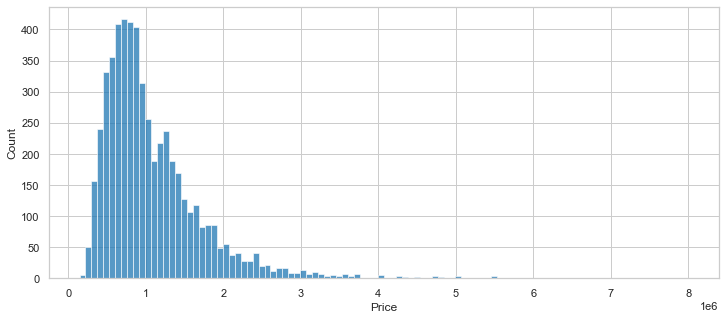

In [12]:
# Price no té nulls ni valors extrems. 
sns.histplot(train_set, x="Price")
plt.show()

In [13]:
# La majoria de preus es troven per sota del 1M$
train_set['Price'].describe()

count    5.432000e+03
mean     1.078470e+06
std      6.470654e+05
min      1.450000e+05
25%      6.500000e+05
50%      9.015000e+05
75%      1.330000e+06
max      8.000000e+06
Name: Price, dtype: float64

### 2.2. Variables descartades

Les següents variables no les farem servir al models de predicció:

+ Lattitude
+ Longitude
+ Suburb
+ Address

### 2.3. Variables numériques sense transformacions

Les següents variables no tenen NaNs i es poden fer servir al model

+ Rooms
+ Distance
+ Propertycount

### 2.2.4. Clean 'Bedroom2'

In [14]:
### Bedroom2 a priori la descartariem. Rooms + bathroom ja obtenim info suficient per explicar el Price
# Possar aquí la transformació de variables

### 2.2.6. Clean 'Car

In [15]:
print(train_set['Car'].isna().sum())


25


In [16]:
class CleanCar(BaseEstimator, TransformerMixin):
  
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X):
        '''
        If null & property type is an house, the value to replace is 2 (integer close to the average)
        Else, if property type is unit or duplex, we suppose the value 0
        '''
        try:
            filter_for_nan_car_in_houses = X['Car'].isnull() & (X['Type']=='h')
            index_to_substitude = X[filter_for_nan_car_in_houses].index
            X.loc[filter_for_nan_car_in_houses, ['Car']] = 2


            filter_for_nan_car_in_houses = X['Car'].isnull() & (X['Type']=='u')
            index_to_substitude = X[filter_for_nan_car_in_houses].index
            X.loc[filter_for_nan_car_in_houses, ['Car']] = 0

        except Exception as e:
            print(f'Error cleaning the car feature, exception missage\n{str(e)}')
        return X

In [17]:
car_pipeline = Pipeline([
        ('clean_car_feature', CleanCar())
    ])

car_tr = car_pipeline.fit_transform(train_set)

### 2.2.6. Clean SellerG

In [18]:
train_set.groupby('SellerG')['SellerG'].transform('size') / train_set['SellerG'].count()

index
0       0.111009
1       0.097018
2       0.097018
3       0.111009
4       0.087997
          ...   
5427    0.111009
5428    0.111009
5429    0.097018
5430    0.043999
5431    0.029639
Name: SellerG, Length: 5432, dtype: float64

In [19]:
# Aquesta variable conté 203 categories al trai_set i 230 al test_set.
# La transformem en el % de cases que ha venut cada seller. D'aquesta
# manera no tindrem problemes en el test_set

def seller_size(data):
    data['SellerG_ratio'] = data.groupby('SellerG')['SellerG'].transform('size') / data['SellerG'].count()
    return data

seller_pipeline = Pipeline([
    ('seller_couts', FunctionTransformer(func = seller_size, validate=False))
])

### 2.2.6. Clean 'Date'

In [20]:
# train_set['Date'] = pd.to_datetime(train_set['Date'], format = '%d/%m/%Y')
# plt.hist(train_set['Date'])
# plt.show()
# Time has an influence on the price of the house, because it captures a change of circunstances, 
# but we have to assess whether this short period (less than a year and a half) is of a single linear trend 
# or if there are ups and downs, in which case we would have to dismiss this variable. 
# Since there is almost no data before 1/05/2016, we will take out these variables to prevent overfitting

In [21]:
# test_set['Date'] = pd.to_datetime(test_set['Date'], format = '%d/%m/%Y')
# plt.hist(test_set['Date'])

In [22]:
# ELIMINEM OBSERVACIONS < 2016-05

# train_set = train_set[(train_set['Date']>'2016-05-01')]

# We see that the effect of the date that the house is sold is not lineal in this period, we discard its use, 
# but if we had a longer period of study we could take a general trend, expected to be upwards due to inflation. However, 
# since the proposed date to separate outliers shows a significant decrease in price, we will take out all houses sold before April 2016

In [23]:
test_set['Date'].describe()


count           8148
unique            57
top       27/05/2017
freq             279
Name: Date, dtype: object

### 2.2.9. Clean 'YearBuilt'

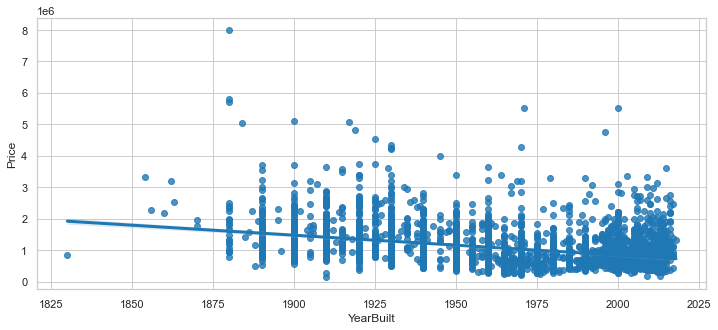

In [24]:
sns.regplot(data=train_set, x="YearBuilt", y="Price")
# plt.axis([-10, 1000, 0, 5e6])
plt.show()

In [25]:
class CleanYearBuild(BaseEstimator, TransformerMixin):
  
    def __init__(self, inferior_limit_for_building_area = 30, superior_limit_for_building_area = 1000):
        self.inferior_limit_for_building_area = inferior_limit_for_building_area
        self.superior_limit_for_building_area = superior_limit_for_building_area
        self.building_area_dict = None
        
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def building_area_extrapolation(self, row = pd.core.series.Series)->pd.core.series.Series:
        row['YearBuilt'] = self.building_area_dict['YearBuilt'][(row['Distance'], row['Bedroom2'])]
        return row
    
    def transform(self, X):
        try:
            self.building_area_dict = X[['Distance', 'Bedroom2', 'YearBuilt']].groupby(by=['Distance', 'Bedroom2']).mean().to_dict()
            
            # Change the NaN and values out of range for the group mean
            X = X.apply(func = lambda x: x if not pd.isna(x['BuildingArea']) else self.building_area_extrapolation(x), axis = 1)          


        except Exception as e:
            print(f'Error cleaning the BuildingArea feature, exception missage:\n{str(e)}')
        return X

In [26]:
year_build_pipeline = Pipeline([
        ('clean_car_feature',CleanYearBuild()),
    ])

#year_build_tr = year_build_pipeline.fit_transform(train_set)

###  2.3.9 Clean 'Regionname'

<AxesSubplot:xlabel='Lattitude', ylabel='Longtitude'>

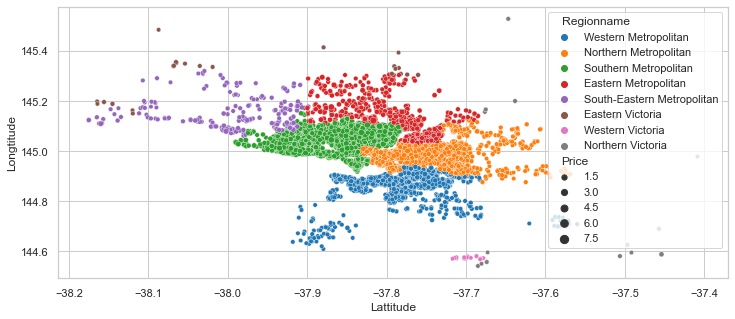

In [27]:
sns.scatterplot(
    data=train_set, x="Lattitude", y="Longtitude", hue="Regionname", size="Price"
)

In [28]:
print("Properties with 0s in this variable: " + str(train_set["Regionname"][train_set["Regionname"]==0].count()))
print("Properties with NaNs in this variable: " + str(train_set['Regionname'].isna().sum()))

Properties with 0s in this variable: 0
Properties with NaNs in this variable: 0


### 2.2.8. Clean 'BuildingArea'

In [29]:
train_set['BuildingArea'].describe()

count     2890.000000
mean       163.462430
std        843.189116
min          0.000000
25%         92.000000
50%        125.000000
75%        174.750000
max      44515.000000
Name: BuildingArea, dtype: float64

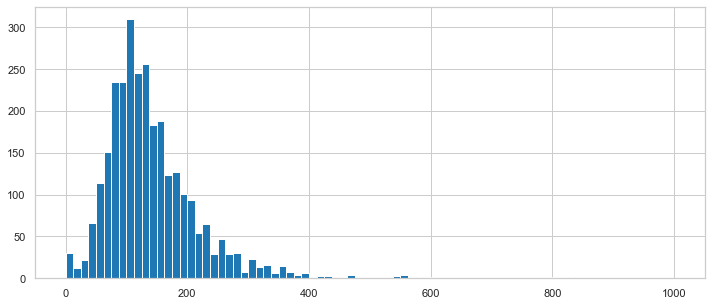

In [30]:
plt.hist(train_set["BuildingArea"],bins=80,range=(0,1000))
plt.show()

### Varis pipelines

In [31]:
# nova variable
from project_tools import AddHouseSize
house_size_pipeline = Pipeline([
        ('add_house_size',AddHouseSize()),
    ])

# Clean Car
from project_tools import CleanCar
car_pipeline = Pipeline([
        ('clean_car_feature',CleanCar()),
    ])

# clean BuildingArea
#from project_tools import CleanBuildingArea

class CleanBuildingArea(BaseEstimator, TransformerMixin):
  
    def __init__(self, inferior_limit_for_building_area = 30, superior_limit_for_building_area = 1000):
        self.inferior_limit_for_building_area = inferior_limit_for_building_area
        self.superior_limit_for_building_area = superior_limit_for_building_area
        self.building_area_dict = None
        
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def building_area_extrapolation(self, row:pd.core.series.Series, round:int, total_building_area_mean:float)->pd.core.series.Series:
        if round == 1:
            row['BuildingArea'] = self.building_area_dict['BuildingArea'][(row['Type'],row['Rooms'])]
        if round == 2:
            row['BuildingArea'] = total_building_area_mean
        return row
    
    def transform(self, X):
        try:
            index_out_of_range = X[(X["BuildingArea"]<self.inferior_limit_for_building_area) | (X["BuildingArea"]>self.superior_limit_for_building_area)].index
            index_in_range = X.index.difference(index_out_of_range)            
            df_in_range = X.iloc[index_in_range]
            self.building_area_dict = df_in_range[['Type', 'Rooms','BuildingArea']].groupby(by=['Type', 'Rooms']).mean().to_dict()
            total_building_area_mean = X['BuildingArea'].mean()
            # Change the NaN and values out of range for the group mean
            X = X.apply(func = lambda x: x if not pd.isna(x['BuildingArea']) else self.building_area_extrapolation(x,1, total_building_area_mean), axis = 1)        
            X = X.apply(func = lambda x: x if x.name not in index_out_of_range else self.building_area_extrapolation(x, 1, 0), axis = 1)        
            X = X.apply(func = lambda x: x if not pd.isna(x['BuildingArea']) else self.building_area_extrapolation(x,2, total_building_area_mean), axis = 1)        
            X['building_area_distance'] = X['BuildingArea']/(X['Distance']+1)


        except Exception as e:
            print(f'Error cleaning the BuildingArea feature, exception missage:\n{str(e)}')
        return X

building_area_pipeline = Pipeline([
        ('clean_ba_feature',CleanBuildingArea()),
    ])

# clean YearBuild
from project_tools import CleanYearBuild
year_build_pipeline = Pipeline([
        ('clean_yb_feature',CleanYearBuild()),
    ])

### Type, method pipeline

In [32]:
# Aquestes dos variables les transformarem amb OneHotEncoder
cat0_pipeline = Pipeline([
    ('one_hot_encoder', OneHotEncoder(sparse = False))
])

## FULL PIPELINE

In [84]:
# llista de variables. La resta de pipelines van contra tot el data set
cat0_attribs = ['Type', 'Method'] 
seller = ['SellerG']

pipeline2 = Pipeline([
    ('add_house_size',AddHouseSize()),
    ('clean_car_feature',CleanCar()),
    ('clean_ba_feature',CleanBuildingArea())
#    ('clean_yb_feature',CleanYearBuild())
])

housing_prepared1 = pipeline2.fit_transform(train_set)

full_pipeline = ColumnTransformer([
    ('seller', seller_pipeline, housing_prepared1.columns), # SellerG
    ('cat0', cat0_pipeline, cat0_attribs) # Type, Method
])

housing_prepared = full_pipeline.fit_transform(housing_prepared1)


In [85]:
# housing_prepared1.isna().sum()

In [86]:
housing_prepared1.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,house_size,building_area_distance
index,,,,,,,,,,,,,,,,,,,,,,,
0,Aberfeldie,241 Buckley St,4,h,1380000.0,VB,Nelson,12/08/2017,7.5,3040.0,4.0,2.0,2.0,766.0,206.774635,NaN,Moonee Valley,-37.75595,144.90551,Western Metropolitan,1543.0,6.0,24.326428
1,Northcote,67 Charles St,2,h,1100000.0,SP,Jellis,20/05/2017,5.5,3070.0,2.0,1.0,1.0,189.0,100.941993,NaN,Darebin,-37.77670,144.99240,Northern Metropolitan,11364.0,3.0,15.529537
2,Balwyn North,42 Maud St,3,h,1480000.0,PI,Jellis,15/10/2016,9.2,3104.0,3.0,1.0,4.0,605.0,116.000000,1950.0,Boroondara,-37.79510,145.06960,Southern Metropolitan,7809.0,4.0,11.372549
3,Brunswick,13 Percy St,3,h,1055000.0,S,Nelson,7/05/2016,5.2,3056.0,3.0,1.0,1.0,324.0,143.784360,1930.0,Moreland,-37.76530,144.95860,Northern Metropolitan,11918.0,4.0,23.191026
4,Templestowe Lower,253 Thompsons Rd,4,h,1000000.0,VB,hockingstuart,13/08/2016,13.8,3107.0,4.0,3.0,2.0,728.0,164.000000,1970.0,Manningham,-37.76800,145.10270,Eastern Metropolitan,5420.0,7.0,11.081081


In [87]:
housing_prepared_df = pd.DataFrame(housing_prepared)
housing_prepared_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,Aberfeldie,241 Buckley St,4,h,1380000.0,VB,Nelson,12/08/2017,7.5,3040.0,4.0,2.0,2.0,766.0,206.774635,NaN,Moonee Valley,-37.75595,144.90551,Western Metropolitan,1543.0,6.0,24.326428,0.111009,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Northcote,67 Charles St,2,h,1100000.0,SP,Jellis,20/05/2017,5.5,3070.0,2.0,1.0,1.0,189.0,100.941993,NaN,Darebin,-37.7767,144.9924,Northern Metropolitan,11364.0,3.0,15.529537,0.097018,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,Balwyn North,42 Maud St,3,h,1480000.0,PI,Jellis,15/10/2016,9.2,3104.0,3.0,1.0,4.0,605.0,116.0,1950.0,Boroondara,-37.7951,145.0696,Southern Metropolitan,7809.0,4.0,11.372549,0.097018,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,Brunswick,13 Percy St,3,h,1055000.0,S,Nelson,7/05/2016,5.2,3056.0,3.0,1.0,1.0,324.0,143.78436,1930.0,Moreland,-37.7653,144.9586,Northern Metropolitan,11918.0,4.0,23.191026,0.111009,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,Templestowe Lower,253 Thompsons Rd,4,h,1000000.0,VB,hockingstuart,13/08/2016,13.8,3107.0,4.0,3.0,2.0,728.0,164.0,1970.0,Manningham,-37.768,145.1027,Eastern Metropolitan,5420.0,7.0,11.081081,0.087997,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [88]:
# data set pel model lineal
linreg_x = housing_prepared[:, [2,8,11,12,13,20,21,22,23,24,25,26,27,28,29,30,31]]
linreg_y = housing_prepared[:, 4]

#### FULL PIPELINE TEST SET

In [89]:
test_prepared1 = pipeline2.fit_transform(test_set)

full_pipeline_test = ColumnTransformer([
    ('seller', seller_pipeline, test_prepared1.columns), # SellerG
    ('cat0', cat0_pipeline, cat0_attribs) # Type, Method
])

test_prepared = full_pipeline_test.fit_transform(test_prepared1)
pd.DataFrame(test_prepared).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,Brighton,1a Mair St,3,h,S,Buxton,6/08/2016,11.2,3186.0,3.0,2.0,3.0,588.0,141.714471,NaN,Bayside,-37.9287,144.992,Southern Metropolitan,10579.0,5.0,11.61594,0.048233,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,West Melbourne,5/467 King St,2,u,S,Jellis,28/05/2016,1.9,3003.0,2.0,1.0,1.0,0.0,83.0,2002.0,Melbourne,-37.8091,144.952,Northern Metropolitan,2230.0,3.0,28.62069,0.096834,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,St Kilda,7/29 Marine Pde,3,u,SP,McGrath,22/04/2017,6.1,3182.0,3.0,1.0,0.0,0.0,115.0,1930.0,Port Phillip,-37.8718,144.9767,Southern Metropolitan,13240.0,4.0,16.197183,0.016323,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,Pascoe Vale,8/16 Pascoe St,3,t,VB,Trimson,18/06/2016,9.9,3044.0,3.0,2.0,1.0,146.0,106.0,2006.0,Moreland,-37.7152,144.9346,Northern Metropolitan,7485.0,5.0,9.724771,0.001227,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,South Kingsville,2/77 Vernon St,2,h,SP,Gunn&Co,24/09/2016,9.1,3015.0,2.0,1.0,2.0,462.0,106.732715,1970.0,Hobsons Bay,-37.8331,144.8715,Western Metropolitan,984.0,3.0,10.567596,0.000859,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [90]:
test_prepared1[test_prepared1['BuildingArea'].isna()]

,Suburb,Address,Rooms,Type,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,house_size,building_area_distance
index,,,,,,,,,,,,,,,,,,,,,,


In [91]:
linreg_test_cols = test_prepared[:, [2,7,10,11,12,19,20,21,22,23,24,25,26,27,28,29,30]]

In [92]:
# pd.DataFrame(linreg_test_cols).isna().sum()

In [93]:
reg = LinearRegression()

# Ajustem el model lineal
reg.fit(linreg_x, linreg_y)


LinearRegression()

### PREDICTIONS

In [94]:
predicted_target = reg.predict(linreg_test_cols)
reg.score(linreg_x,linreg_y)

0.48268555354610865

In [95]:
predicted_target

array([1275420.57942208,  971449.35710583,  652737.17644945, ...,
        818148.46440339, 1279416.9912593 ,  984973.39222472])

In [96]:
df_output = pd.DataFrame(predicted_target)
df_output = df_output.reset_index()
df_output.columns = ['index','Price']

df_output.to_csv('results.csv',index=False)